# 598RL HW3b

In [1]:
#import basic packages
%matplotlib inline
import gym.spaces
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from IPython import display
plt.ion()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import my_acrobot
env = gym.make('MyAcrobot-v0')

device = torch.device("cuda")

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(6, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

In [4]:
BATCH_SIZE = 512
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100
TARGET_UPDATE = 5

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

cumulative_reward = []
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            #print(state)
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(3)]], device=device, dtype=torch.long)

In [5]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)#.float()

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    #print(type(next_state_values), type(GAMMA), type(reward_batch))
    #print(next_state_values, GAMMA, reward_batch)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
num_episodes = 201
num_steps = 1000

for i_episode in range(num_episodes):
    
    total_reward = 0.0    
    # Initialize the environment and state
    asd = env.reset(action_m=2.0)
    state = torch.tensor([env._get_ob()], device=device).float() 
#     print(asd)
#     print(state)
    
    for t in range(num_steps):
        # Select and perform an action
        action = select_action(state)
        
        _, reward, done, _ = env.step(action.item())
        total_reward += reward
        reward = torch.tensor([reward], device=device)
        
        # Observe new state
        if not done:
            next_state = torch.tensor([env._get_ob()], device=device).float()
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()

    cumulative_reward.append(total_reward)
        
    display.clear_output(wait=True)
    print(i_episode, cumulative_reward[i_episode])
        
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        print('Updating target', i_episode)
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
# env.render()
env.close()
plt.ioff()
plt.show()

192 27.811965005693935


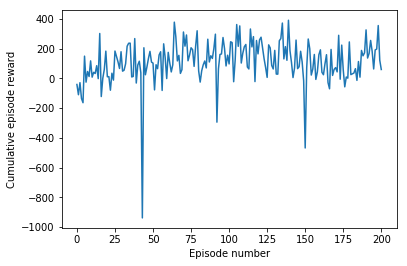

In [9]:
plt.plot(cumulative_reward)
plt.xlabel('Episode number')
plt.ylabel('Cumulative episode reward')
plt.show()

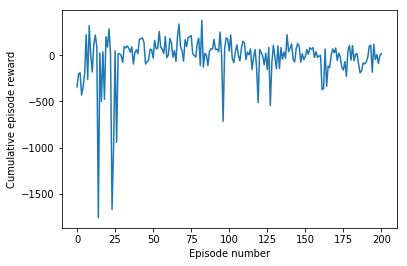

In [7]:
plt.plot(cumulative_reward)
plt.xlabel('Episode number')
plt.ylabel('Cumulative episode reward')
plt.show()